# Vehicle Detection and Tracking
The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import glob

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


## Extract feature
Combine color features & hog features together

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, visualise=True, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=feature_vec)
        return features
    
def convert_color(img, conv):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace == 'RGB':
            feature_image = np.copy(img)
        elif cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        # Apply bin_spatial() to get spatial color features
        spatial_feature = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features() to get HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_feature, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [3]:
vehicles_files = ['vehicles/GTI_Far/image*.png', 'vehicles/GTI_Left/image*.png', 
                  'vehicles/GTI_MiddleClose/image*.png', 'vehicles/GTI_Right/image*.png',
                  'vehicles/KITTI_extracted/*.png']
no_vehicles_files = ['non-vehicles/Extras/extra*.png', 'non-vehicles/GTI/image*.png']
car_image = []
not_car_image = []
car_feature = []
not_car_feature = []
for f in vehicles_files:
    car_image.extend(glob.glob(f))
for f in no_vehicles_files:
    not_car_image.extend(glob.glob(f))
print(len(car_image))
print(len(not_car_image))
car_image = shuffle(car_image)
not_car_image = shuffle(not_car_image)

8792
8968


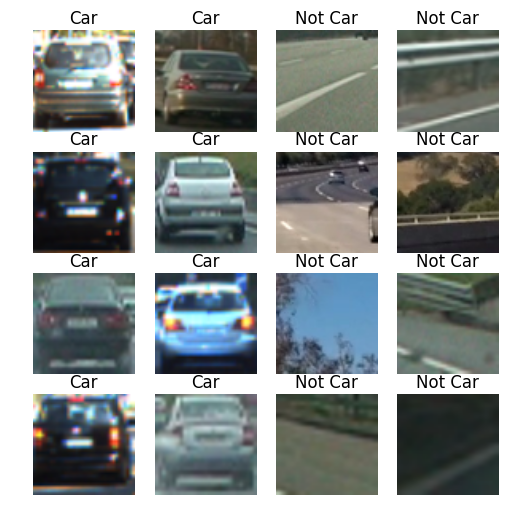

In [4]:
plt.subplots(4, 4, figsize=(6, 6))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    if i % 4 < 2:
        plt.title('Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(car_image[i]))
    else:
        plt.title('Not Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(not_car_image[i]))

In [5]:
car_feature = extract_features(car_image, cspace='HLS', hog_channel='ALL')
not_car_feature = extract_features(not_car_image, cspace='HLS', hog_channel='ALL')

# Create an array stack of feature vectors
X = np.vstack((car_feature, not_car_feature)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_feature)), np.zeros(len(not_car_feature))))

## Train a SVM classifier

In [24]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)

svc = LinearSVC()
# Check the training time for the SVC
print("Start training...")
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Start training...
22.31 Seconds to train SVC...
Test Accuracy of SVC =  0.987


## Sliding Windows

In [7]:
def find_cars(img, svc, X_scaler, ystart=400, ystop=656, scale=1.5,
              orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # return box list
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 print((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    return box_list

In [8]:
def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    # Return the image
    return img

# Video Pipeline

In [9]:
class Box:
    def __init__(self, time_range):
        self.time_range = time_range
        self.box_list = []
    def add(self, boxs):
        self.box_list.append(boxs)
        if len(self.box_list) > self.time_range:
            self.box_list.pop(0)
    def get(self):
        ret = []
        for box in self.box_list:
            ret += box
        return ret    

In [27]:
video_images = []
def process_image(img):
    video_images.append(img)
    box_list = find_cars(img, svc, X_scaler)
    box.add(box_list)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box.get())
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 30)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result= draw_labeled_bboxes(np.copy(img), labels)
    return result

In [28]:
video = 'project_video_result.mp4'
clip = VideoFileClip("project_video.mp4")
box = Box(40)
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video, audio=False)

/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_result.mp4
----------------------------------------

Writing video into project_video_result.mp4


100%|██████████| 1210/1210 [06:42<00:00,  3.11it/s]


Done writing video in project_video_result.mp4 !
Your video is ready !
CPU times: user 4min 58s, sys: 1min 55s, total: 6min 54s
Wall time: 6min 43s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

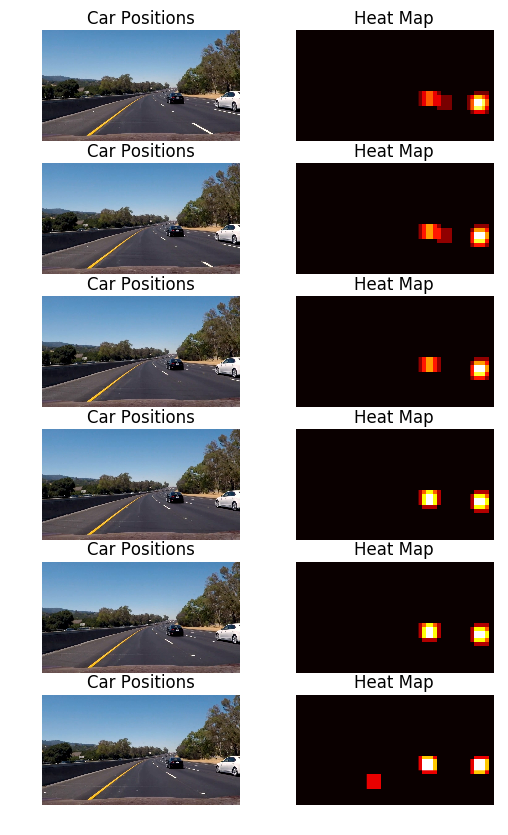

In [13]:
img_list = []
heat_list = []
heat_total = np.zeros_like(video_images[0][:,:,0]).astype(np.float)

for i in range(1050, 1056):
    img = np.copy(video_images[i])
    box_list = find_cars(img, svc, X_scaler)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    heat_total = add_heat(heat_total, box_list)
    img_list.append(img)
    heat_list.append(heat)

plt.subplots(6, 2, figsize=(6, 10))
for i in range(0, 6):
    plt.subplot(6, 2, i*2+1)
    plt.title('Car Positions')
    plt.axis('off')
    plt.imshow(img_list[i])
    plt.subplot(6, 2, i*2+2)
    plt.title('Heat Map')
    plt.axis('off')
    plt.imshow(heat_list[i], cmap='hot')


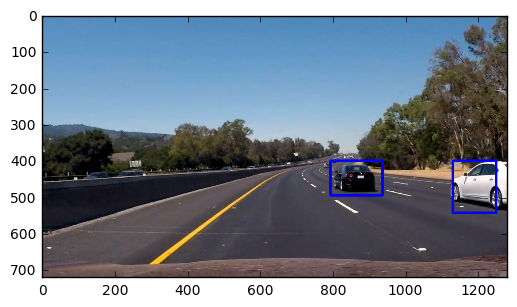

In [14]:
# Apply threshold to help remove false positives
heat = apply_threshold(heat_total, 4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img_list[-1]), labels)
plt.imshow(draw_img)